<a href="https://colab.research.google.com/github/ovoma-commits/Team12_STA160/blob/main/STA_141_Project_RQ_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()
CSV_PATH = list(uploaded.keys())[0]

Saving davis_coffee_merged_GY.csv to davis_coffee_merged_GY.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

np.random.seed(20251117)

def find_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def zscore(s):
    sd = s.std(ddof=0)
    if pd.isna(sd) or sd == 0:
        return s*0
    return (s - s.mean())/sd

def spearman_with_bootstrap(x, y, n_boot=2000, seed=20251117):
    d = pd.DataFrame({"x": x, "y": y}).dropna()
    n = len(d)
    if n < 5:
        return np.nan, (np.nan, np.nan), np.nan, n
    rho, p = spearmanr(d["x"], d["y"])
    rs = np.random.default_rng(seed)
    idx = np.arange(n)
    boots = []
    for _ in range(n_boot):
        samp = rs.choice(idx, size=n, replace=True)
        r, _ = spearmanr(d["x"].values[samp], d["y"].values[samp])
        boots.append(r)
    boots = np.array(boots, float)
    lo, hi = np.nanpercentile(boots, [2.5, 97.5])
    return rho, (lo, hi), p, n

def weighted_bin_smooth(x, y, w=None, nbins=16):
    x = np.asarray(x); y = np.asarray(y)
    w = np.ones_like(y) if w is None else np.asarray(w)
    w = np.where(w>0, w, 1e-9)
    qs = np.linspace(0, 1, nbins+1)
    edges = np.quantile(x, qs)
    xs, ys = [], []
    for i in range(nbins):
        lo, hi = edges[i], edges[i+1]
        mask = (x >= lo) & (x <= hi) if i == nbins-1 else (x >= lo) & (x < hi)
        if not mask.any():
            continue
        xb = np.average(x[mask], weights=w[mask])
        yb = np.average(y[mask], weights=w[mask])
        xs.append(xb); ys.append(yb)
    xs = np.array(xs); ys = np.array(ys)
    if len(xs) > 1:
        order = np.argsort(xs); xs, ys = xs[order], ys[order]
    return xs, ys

In [ ]:
df = pd.read_csv(CSV_PATH)

google_rating = find_col(df, ["google_rating","Google_rating","google_stars","googleStars"])
yelp_rating   = find_col(df, ["yelp_rating","Yelp_rating","yelp_stars","yelpStars"])
google_count  = find_col(df, ["google_review_count","Google_review_count","google_reviews","googleReviewCount"])
yelp_count    = find_col(df, ["yelp_review_count","Yelp_review_count","yelp_reviews","yelpReviewCount"])
avg_hours     = find_col(df, ["avg_daily_hours","avg_hours","avg_open_hours"])

assert (google_rating is not None) and (yelp_rating is not None), \
       "Missing platform rating columns (google_rating / yelp_rating)."
assert (avg_hours is not None), "Missing avg_daily_hours (generate it in FE)."

df_r = df[[google_rating, yelp_rating, avg_hours, google_count, yelp_count]].dropna(subset=[google_rating, yelp_rating]).copy()

df_r["gap_abs"] = (df_r[google_rating] - df_r[yelp_rating]).abs()
df_r["g_z"] = zscore(df_r[google_rating])
df_r["y_z"] = zscore(df_r[yelp_rating])
df_r["gap_abs_std"] = (df_r["g_z"] - df_r["y_z"]).abs()

if (google_count is not None) and (yelp_count is not None):
    df_r["w"] = np.minimum(df_r[google_count], df_r[yelp_count])
else:
    df_r["w"] = np.nan

n_pairs = df_r.shape[0]
n_main = df_r.dropna(subset=[avg_hours]).shape[0]
median_hours = df_r[avg_hours].median()
q1, q3 = df_r[avg_hours].quantile([0.25, 0.75])

print(f"Pairs with both ratings: {n_pairs}")
print(f"Main n (non-missing {avg_hours}): {n_main}")
print(f"{avg_hours} median (IQR): {median_hours:.2f} ({q1:.2f}–{q3:.2f})")

Pairs with both ratings: 33
Main n (non-missing avg_daily_hours): 31
avg_daily_hours median (IQR): 11.29 (10.00–12.00)


In [ ]:
rows = []
def add_row(name, gap_name, x, y):
    rho, (lo, hi), p, n = spearman_with_bootstrap(x, y, n_boot=2000, seed=20251117)
    rows.append({"feature": name, "gap": gap_name, "rho": rho, "ci_low": lo, "ci_high": hi, "p_value": p, "n": n})

add_row("avg_daily_hours", "|Δ|",        df_r[avg_hours], df_r["gap_abs"])
add_row("avg_daily_hours", "|Δ| (std)",  df_r[avg_hours], df_r["gap_abs_std"])

tbl = pd.DataFrame(rows)
tbl.to_csv("tbl_rq1_correlations.csv", index=False)
tbl

,feature,gap,rho,ci_low,ci_high,p_value,n
0,avg_daily_hours,|Δ|,-0.285442,-0.633345,0.126982,0.119577,31
1,avg_daily_hours,|Δ| (std),-0.226933,-0.519520,0.128373,0.219567,31


In [ ]:
influence_note = "Influence check skipped."
if "w" in df_r.columns and df_r["w"].notna().sum() >= 2:
    dsub = df_r[[avg_hours,"gap_abs","w"]].dropna()
    if len(dsub) >= 6:
        r0, _, _, n0 = spearman_with_bootstrap(dsub[avg_hours], dsub["gap_abs"])
        idx_max = dsub["w"].idxmax()
        dsub2 = dsub.drop(index=idx_max)
        r1, _, _, n1 = spearman_with_bootstrap(dsub2[avg_hours], dsub2["gap_abs"])
        influence_note = f"Exclude top-1 by w: rho {r0:.3f}→{r1:.3f}, n {n0}→{n1}."
influence_note

'Exclude top-1 by w: rho -0.285→-0.232, n 31→30.'

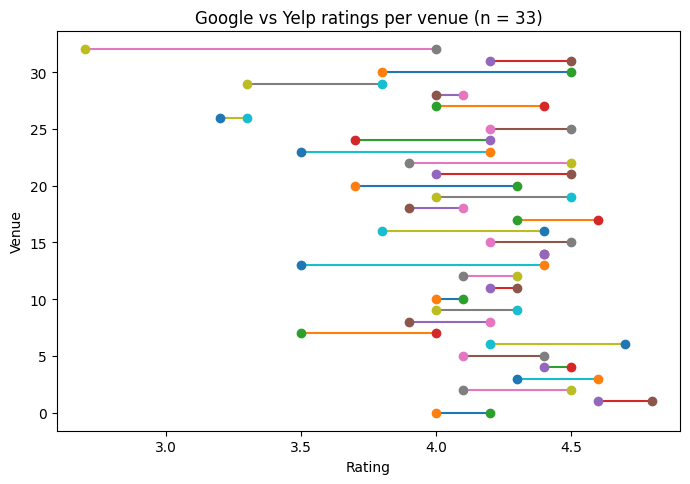

In [ ]:
d_db = df_r[[google_rating, yelp_rating]].dropna().reset_index(drop=True)
n_eff = len(d_db)

plt.figure(figsize=(7, max(4, n_eff*0.15)))
for i, row in d_db.iterrows():
    g = row[google_rating]; yv = row[yelp_rating]
    xa, xb = (yv, g) if yv <= g else (g, yv)
    plt.plot([xa, xb], [i, i])
    plt.plot([yv], [i], marker='o')
    plt.plot([g],  [i], marker='o')
plt.xlabel("Rating")
plt.ylabel("Venue")
plt.title(f"Google vs Yelp ratings per venue (n = {n_eff})")
plt.tight_layout()
plt.savefig("fig_rq1_dumbbell.png", dpi=200)
plt.show()

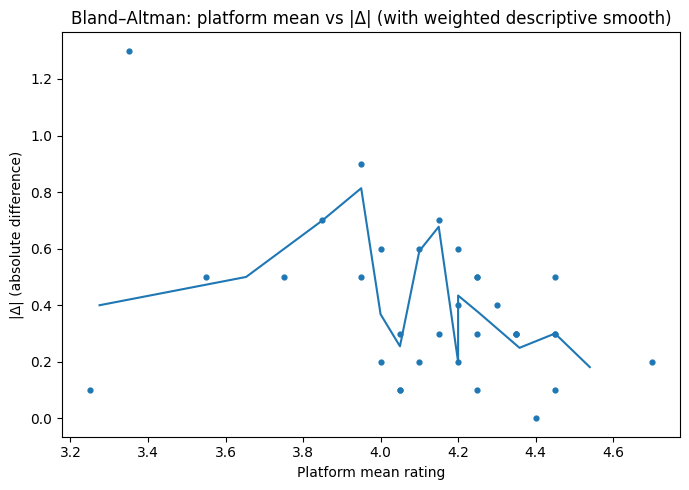

In [ ]:
d_ba = df_r[[google_rating, yelp_rating, "gap_abs", "w"]].dropna().copy()
d_ba["mean_xy"] = (d_ba[google_rating] + d_ba[yelp_rating]) / 2.0

xs, ys = weighted_bin_smooth(d_ba["mean_xy"].values, d_ba["gap_abs"].values,
                             w=d_ba["w"].values if "w" in d_ba.columns else None, nbins=16)

plt.figure(figsize=(7,5))
plt.scatter(d_ba["mean_xy"], d_ba["gap_abs"], s=12)
if len(xs) > 1:
    plt.plot(xs, ys)
plt.xlabel("Platform mean rating")
plt.ylabel("|Δ| (absolute difference)")
plt.title("Bland–Altman: platform mean vs |Δ| (with weighted descriptive smooth)")
plt.tight_layout()
plt.savefig("fig_rq1_bland_altman.png", dpi=200)
plt.show()

In [ ]:
from google.colab import files
files.download("fig_rq1_dumbbell.png")
files.download("fig_rq1_bland_altman.png")
files.download("tbl_rq1_correlations.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>